# Importer les librairies

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Fonctions générales

In [2]:
# Pour le calcul d'un D de cohen
def cohen(x,y, t):
    return (t*np.sqrt((x+y)/(x*y)))

# Importer les données

In [3]:
data = pd.read_csv("Data/titanic.csv")
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Questions

## 1. Préparation des données

Remplissez la function `preprocess` ci-dessus. Celle-ci doit:
1. Supprimez les colonnes `PassengerId`, `Name`, `Ticket`, `Cabin`.
2. Supprimez les lignes contenant au moins une valeur manquante.
3. Créer une variable `FamilySize` qui est correspond à `SibSp` + `Parch` + 1. Supprimez les variables `SibSp` et `Parch`.
4. Recalculer le prix du billet `Fare` en divisant `Fare` par `FamilySize`.
5. Encoder les variables qualitatives `Sex`, `Embarked` avec l'argument `drop_first=True`.

In [4]:
def preprocess(data: pd.DataFrame) -> pd.DataFrame:

    """La fonction prépare les données à l'analyse.

    Args:
        data (pd.DataFrame): La dataframe originale

    Returns:
        pd.DataFrame: La dataframe preprocessé et prête à être analysée.
    """

    # Faire une copy de la dataframe originale
    data_preprocessed = data.copy()

    # Supprimez les variables `PassengerId`, `Name`, `Ticket` & `Cabin`
    data_preprocessed = data_preprocessed.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])

    # Supprimez lignes contenant au moins une valeur manquante
    data_preprocessed = data_preprocessed.dropna()

    # Créer une variable `FamilySize` et supprimez les variables `SibSp` et `Parch`
    data_preprocessed["FamilySize"] = data_preprocessed["SibSp"] + data_preprocessed["Parch"] + 1
    data_preprocessed = data_preprocessed.drop(columns=["SibSp", "Parch"])

    # Recalculer le prix du billet
    data_preprocessed["Fare"] = data_preprocessed["Fare"] / data_preprocessed["FamilySize"]

    # Encode (OHE) `Sex` & `Embarked`
    data_preprocessed = pd.get_dummies(
        data_preprocessed,
        columns=["Sex", "Embarked"],
        drop_first=True,
        dtype=int
    )



    # CHECK: NE PAS TOUCHER
    for col in ["PassengerId", "Name", "Ticket", "Cabin", "SibSp", "Parch"]:
        assert col not in data_preprocessed, f"{col} n'a pas été retiré."
    assert data_preprocessed.isna().sum().sum() == 0, "Il reste encore des NaN à supprimer."
    assert "FamilySize" in data_preprocessed.columns, "La colonne `FamilySize` n'a pas été créée."
    assert data_preprocessed.loc[0, "Fare"] == 3.625, "La colonne `Fare` n'a pas été recalculée."
    for col in [col for col in data_preprocessed if col.startswith("Embarked")]:
        assert data_preprocessed[col].nunique() == 2, f"{col} n'a pas été encodé."
    for col in [col for col in data_preprocessed if col.startswith("Sex")]:
        assert data_preprocessed[col].nunique() == 2, f"{col} n'a pas été encodé."

    return data_preprocessed

Le résultat de la function doit vous donner exactement le tableau ci-dessous.

In [5]:
# Preprocess les données à l'aide de la function `preprocess`
data_clean = preprocess(data)
display(data_clean)

,Survived,Pclass,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,3.625000,2,1,0,1
1,1,1,38.0,35.641650,2,0,0,0
2,1,3,26.0,7.925000,1,0,0,1
3,1,1,35.0,26.550000,2,0,0,1
4,0,3,35.0,8.050000,1,1,0,1
...,...,...,...,...,...,...,...,...
885,0,3,39.0,4.854167,6,0,1,0
886,0,2,27.0,13.000000,1,1,0,1
887,1,1,19.0,30.000000,1,0,0,1
889,1,1,26.0,30.000000,1,1,0,0


In [6]:
data_clean.describe()

,Survived,Pclass,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.404494,2.240169,29.642093,20.736106,1.946629,0.636236,0.039326,0.778090
std,0.491139,0.836854,14.492933,37.544783,1.485027,0.481420,0.194506,0.415823
min,0.000000,1.000000,0.420000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,20.000000,7.318750,1.000000,0.000000,0.000000,1.000000
50%,0.000000,2.000000,28.000000,9.225000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,3.000000,38.000000,26.000000,2.000000,1.000000,0.000000,1.000000
max,1.000000,3.000000,80.000000,512.329200,8.000000,1.000000,1.000000,1.000000


## 2. Inférence statistique (4 pts)

### Q1: L'âge moyen des passagers du Titanic est-il le même que l'âge moyen de la population en 1912 (28 ans) ?

#### Q1.1. Identifier la ou les variables d'intérêt et spécifier le type.

Variable *Age*, type *Quantitatif, continue*

#### Q1.2. Réaliser une visualisation appropriée selon la ou les variables.

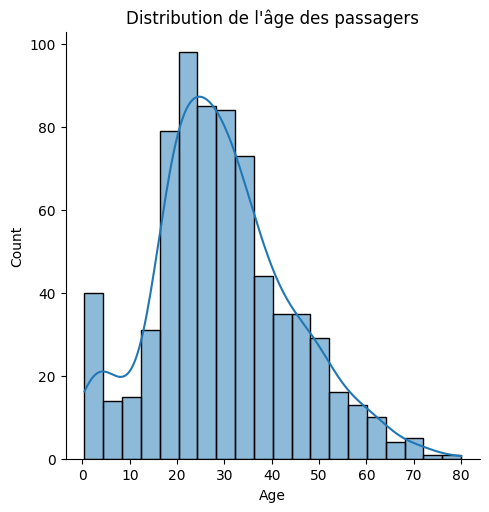

In [7]:
sns.displot(
    data=data_clean,
    x="Age",
    kde=True
)
plt.title("Distribution de l'âge des passagers")
plt.show()

#### Q1.3. Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.

**H0:** L'âge moyen des passagers est *identique* à celui de la population en 1912 (28 ans).  
**H1:** L'âge moyen des passagers est *différent* de celui de la population en 1912 (28 ans).

#### Q1.4. Identifier le test statistique approprié selon les hypothèses énoncées.

Nous devons réaliser un t-test (car nous n'avons pas l'écart type de la population de 1912) pour comparer la moyenne de l'age de notre échantillon à celle de la population en 1912.

#### Q1.5. Vérifier la validation des assumptions selon le test identifié.

1. *Les échantillons sont aléatoires.*  
    L'échantillon fourni représente un peu plus d'un tiers des passagers du Titanic. A priori cet échantillon n'est pas aléatoire au sens statistique, mais suffisament représentatif de la population du titanic (https://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf).
    Nous avons retiré 180 lignes incomplétes.  
2. *La taille de l'échantillon est supérieur à 30 et la population est normalement distribué.*  
    Notre échantillon est supérieur à 30 et la population est proche de normalement distribuée.

#### Q1.6. Calculer la statistique ainsi que la p-valeur.

In [8]:
mean_1912_population_age = 28
print("Moyenne age titanic : ", np.mean(data_clean["Age"]))

t, p_value = stats.ttest_1samp(data_clean["Age"], popmean=mean_1912_population_age)

print("La statistique t est de : " + str(t))
print("La p-valeur associée est de : " + str(p_value))

nb_Titanic_Population = data_clean["Age"].count()
#Estimation de la population mondiale en 1912, source : https://en.wikipedia.org/wiki/World_population
nb_World_Population_1912 = 1800000000
d_effec_size = cohen(nb_Titanic_Population, nb_World_Population_1912, t)
print("La taille de l'effet est de selon la formule du d de Cohen : " + str(d_effec_size))

Moyenne age titanic :  29.64209269662921
La statistique t est de : 3.0233009800374053
La p-valeur associée est de : 0.002590259537786662
La taille de l'effet est de selon la formule du d de Cohen : 0.11330301690432623


#### Q1.7. Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%.

In [9]:
"On rejette l'hypothèse nulle" if p_value < 0.05 else "On ne rejette pas l'hypothèse nulle"

"On rejette l'hypothèse nulle"

#### Q1.8. Interpréter le résultat et évaluer la taille de l'effet.

Nous constatons que : la p-value obtenue est faible, **0.0025**. Ce qui doit nous amener a la rejeter en considérant un seuil à 0.05.
Aussi, la taille de l'effet est considérée comme faible : **0.11**.

Pour rappel, la moyenne d'age du titanic est de **1.6** année supérieure a la moyenne mondiale de 1912. Cette différence, bien que paraissant faible en valeur absolue, est une différence statistiquement significative aux yeux du t-test effectué.

En d'autres termes, une p-value de **0.0025** nous laisse penser que l'hypothèse nulle proposée n'est pas une hypothèse satisfaisante.

Etant donné la petite population du titanic en regard de la taille de la population mondiale, nous comprenons pourquoi la taille de l'effet est si faible. Malgré que la différence des moyennes soit sinificative, la taille de l'effet nous l'aisse penser que cette différence d'age n'a que peut d'importance. Cela peut s'expliquer par la petite taille de l'échantillon par rapport a la taille de la population.
Cependant, le fait que la p-valeur soit significative doit quand même nous laisser penser qu'il y a de potentiels facteurs a explorer qui pouraient influencer cette différence de moyenne d'age.

### Q2: La survie dépend-elle de la classe du passager ?

#### Q2.1. Identifier la ou les variables d'intérêt et spécifier le type.

Il nous faudra la variable `Pclasss` ainsi que la variable `Survived`. La première est qualitative ordinale, et la seconde est qualitative nominale.

#### Q2.2. Réaliser une visualisation appropriée selon la ou les variables.

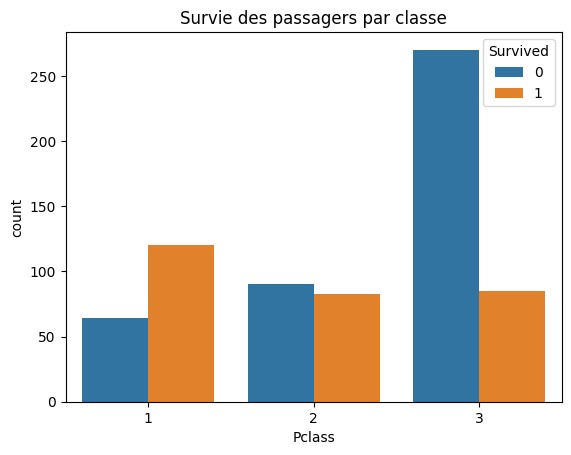

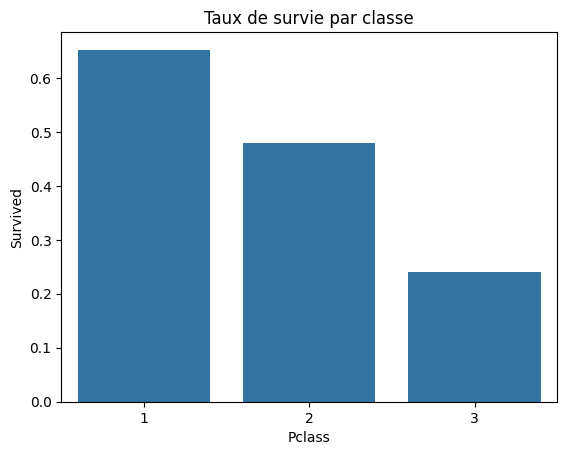

In [10]:
sns.countplot(
    data=data_clean,
    x="Pclass",
    hue="Survived"
)
plt.title("Survie des passagers par classe")
plt.show()

sns.barplot(
    data=data_clean,
    x="Pclass",
    y="Survived",
    errorbar=None
)
# Display percentage on bars
plt.title("Taux de survie par classe")
plt.show()

#### Q2.3. Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.

*H0:* La survie ne dépend pas de la classe des passagers.  
*H1:* La survie dépend de la classe des passagers.

#### Q2.4. Identifier le test statistique approprié selon les hypothèses énoncées.

Le test chi2 nous permettra de tester la dépendance entre les variables `Pclass` et `Survived`.

#### Q2.5. Vérifier la validation des assumptions selon le test identifié.

1. *Les échantillons sont aléatoires.*  
    L'échantillon fourni représente un peu plus d'un tiers des passagers du Titanic. A priori cet échantillon n'est pas aléatoire au sens statistique, mais suffisament représentatif de la population du titanic (https://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf).
    Nous avons retiré 180 lignes incomplétes.
2. *5 valeurs minimum par combinaisons de variables.*  
    Nous avons plus de 50 valeurs par combinaisons.

#### Q2.6. Calculer la statistique ainsi que la p-valeur.

In [11]:
chi2, p_value, dof, _ = stats.chi2_contingency(
    pd.crosstab(data_clean["Pclass"], data_clean["Survived"])
)
# Cramer's V, to calculate the effect size
effect_size = np.sqrt(chi2 / (data_clean.shape[0] * (min(data_clean.shape) - 1)))

print("La statistique chi2 est de : " + str(chi2))
print("La p-valeur associée est de : " + str(p_value))
print("Le degré de liberté est de : " + str(dof))
print("La taille de l'effet est de : " + str(effect_size))

La statistique chi2 est de : 91.08074548791019
La p-valeur associée est de : 1.6675060315554636e-20
Le degré de liberté est de : 2
La taille de l'effet est de : 0.13518368210284873


#### Q2.7. Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%.

In [12]:
"On rejette l'hypothèse nulle" if p_value < 0.05 else "On ne rejette pas l'hypothèse nulle"

"On rejette l'hypothèse nulle"

#### Q2.8. Interpréter le résultat et évaluer la taille de l'effet.

La p-value obtenue est particulièrement faible, cela nous amêne a rejeter l'hypothèse nulle. Ces valeurs nous montrent qu'il y a vraisemblament des facteurs qui agissent sur la survie des passageers, dans notre cas, la classe du passager. Afin d'en avoir le coeur net, il serait intéressant de tester un certains nobre d'hypothèses pour mieux comprendre les facteurs qui influent sur la survie des passagers.
En effet, il n'est pas impossible que des facteurs de confusion soient présents, par exemple, on peut imaginer que le placement des quartiers première classe est plus proche des canots, dans ce cas, la classe nous indiquerait une tendance, mais ne serait pas la réelle cause de la survie ou non.

Pour finir, la taille de l'effet est faible (moins de 0.2), cela nous indique q'il semble que nos deux variables, malgré une p-value faible, ne sont pas fortement liées. Cela peut d'avantage apuier l'idée que la classe n'est potentiellement pas le facteur direct ou principal de la survie des passagers.

### Q3: Existe-t-il une différence d'âge entre les passagers qui ont survécu et les passagers décédés ?

#### Q3.1. Identifier la ou les variables d'intérêt et spécifier le type.

La variable `Survived` est qualitative nominale, et la variable `Age` est quantitative continue.

#### Q3.2. Réaliser une visualisation appropriée selon la ou les variables.

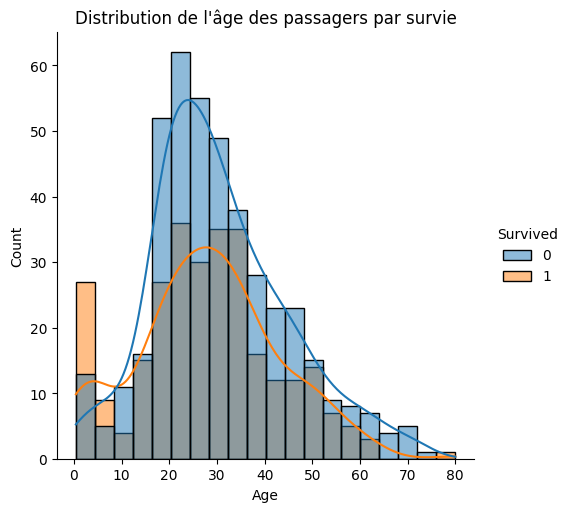

In [13]:
# Graph with one distribution per survival status
sns.displot(
    data=data_clean,
    x="Age",
    hue="Survived",
    kde=True
)
plt.title("Distribution de l'âge des passagers par survie")
plt.show()

#### Q3.3. Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.

*H0:* L'age n'influence pas le taux de survie des passagers.  
*H1:* L'age influence le taux de survie des passagers.

#### Q3.4. Identifier le test statistique approprié selon les hypothèses énoncées.

Nous pouvons réaliser un t-test a 2 échantillons, afin de comparer les moyenne d'age des survivants aux décédés.

#### Q3.5. Vérifier la validation des assumptions selon le test identifié.

1. *Les échantillons sont aléatoires.*  
    L'échantillon fourni représente un peu plus d'un tiers des passagers du Titanic. A priori cet échantillon n'est pas aléatoire au sens statistique, mais suffisament représentatif de la population du titanic (https://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf).
    Nous avons retiré 180 lignes incomplétes.
2. *Les échantillons sont indépendants.*  
    Nos 2 échantillons sont indépendants.
3. *La taille des l'échantillon est supérieur à 30 et la population est normalement distribué.*  
    Nos échantillons sont supérieurs à 30 et la population est proche de normalement distribuée.

#### Q3.6. Calculer la statistique ainsi que la p-valeur.

In [14]:
t, p_value = stats.ttest_ind(
    data_clean.loc[data_clean["Survived"] == 0, "Age"],
    data_clean.loc[data_clean["Survived"] == 1, "Age"]
)
effect_size = cohen(
    len(data_clean.loc[data_clean["Survived"] == 0, "Age"]),
    len(data_clean.loc[data_clean["Survived"] == 1, "Age"]),
    t
)
print("La statistique t est de : " + str(t))
print("La p-valeur associée est de : " + str(p_value))
print("La taille de l'effet est de : " + str(effect_size))

La statistique t est de : 2.2043427748445956
La p-valeur associée est de : 0.027820316250851285
La taille de l'effet est de : 0.16832163955075485


#### Q3.7. Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%.

In [15]:
"On rejette l'hypothèse nulle" if p_value < 0.05 else "On ne rejette pas l'hypothèse nulle"

"On rejette l'hypothèse nulle"

#### Q3.8. Interpréter le résultat et évaluer la taille de l'effet.

### Q4: Existe-t-il une relation entre l'âge des passagers et le prix des billets ?

#### Q4.1. Identifier la ou les variables d'intérêt et spécifier le type.

La deux variables `Age` et `Fare` sont quantitatives continues.

#### Q4.2. Réaliser une visualisation appropriée selon la ou les variables.

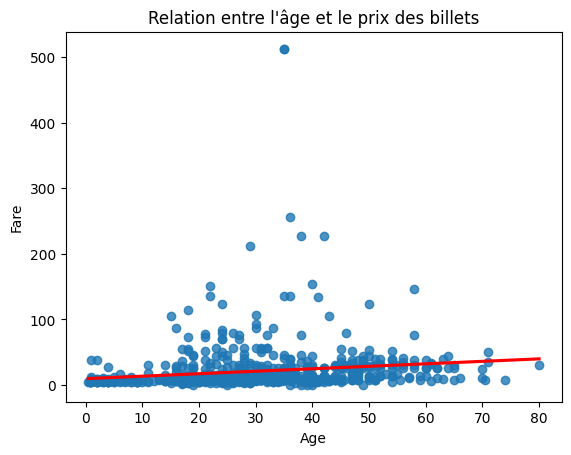

In [16]:
sns.regplot(
    data=data_clean,
    x="Age",
    y="Fare",
    ci=None,
    line_kws={"color": "red"}
)
plt.title("Relation entre l'âge et le prix des billets")
plt.show()

#### Q4.3. Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.

*H0:* Nous n'observons pas de relation entre l'age et le prix des billets.  
*H1:* Nous observons une relation entre l'age et le prix des billets.

#### Q4.4. Identifier le test statistique approprié selon les hypothèses énoncées.

Il nous faut réaliser un test de corrélation entre les 2 variables.

#### Q4.5. Vérifier la validation des assumptions selon le test identifié.

1. *Les 2 variables doivent être quantitatives.* OK
2. *Les données doivent être approximativement liées linéairement.* A priori pas, ou trop faiblement.
3. *Les résidus de la régression linéaire sont indépendants* Oui.
4. *Les résidus de la régression linéaire sont normalement distribués* Oui.
5. *Les résidus de la régression linéaire sont distribuées de façon homogène* Oui.

#### Q4.6. Calculer la statistique ainsi que la p-valeur.

A priori la relation n'est pas linéaire car nous ne remplissons pas les assumptions. Cependant, nous pouvons réaliser un test de corrélation pour l'essai :

In [17]:
# Correlation test
corr = data_clean.corr()["Age"]["Fare"]
print("La corrélation entre l'age et le prix des billets est de : " + str(corr))

La corrélation entre l'age et le prix des billets est de : 0.14563315923055964


Une corrélation en dessous de 0.3 est considérée comme faible. Sachant que nous ne respectons pas totalement les assumptions, nous ne pouvons pas conclure sur la relation entre l'age et le prix des billets.

#### Q4.7. Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%.

Nous n'avons pas calculé de p-valeur car nous ne respectons pas les assumptions pour le test de corrélation.

#### Q4.8. Interpréter le résultat et évaluer la taille de l'effet.

Le test de corrélation n'est pas concluant et ne nous offre pas les éléments qui nous permetterait de trancher entre nos 2 hypothèses. Si nous souhaitons explorer d'avantage le lien entre ces 2 variables, il nous faudrait proposer d'autres hypothèses afin que nous puissions mettre en place d'autres tests. Peut être que d'autre facteurs influencent plus massivement le prix des billets. Ou que la corrélation n'est pas linéaire.


### Quelques liens utiles pour la taille de l'effet:
* [https://rpsychologist.com/cohend/](https://rpsychologist.com/cohend/)
* [https://datatab.net/tutorial/effect-size-independent-t-test](https://datatab.net/tutorial/effect-size-independent-t-test)
* [https://www.simplypsychology.org/effect-size.html](https://www.simplypsychology.org/effect-size.html)

## 3. Data mining (2 pts)

### Q1: Effectuer une analyse statistique à l'aide de la régression logistique avec comme variable dépendente la variable `Survived`. Interpréter les coefficients et discuter de leur importance statistique en vous appuyant sur leur p-valeur.

Lors des questions précédentes, nous avons pu constater de potentiels liens entre la survie des passagers et la classe, l'age, le prix des billets.
Pour nos essais, nous allons aussi inclure la taille de la famille et le sexe.

Nous avons réalisé plusieurs essais avec différentes combinaisons des variables énoncées ci dessus afin de trouver un model qui nous semblait intéressant.
Nous nous sommes arrètes sur l'utilisation des variables **Age, Classe, FamiliySize et Sexe**.

Avec un pair plot, nous pouvons rapidement observer a quoi ressemblent les relations entre ces variables, au regard de la survie des passagers :

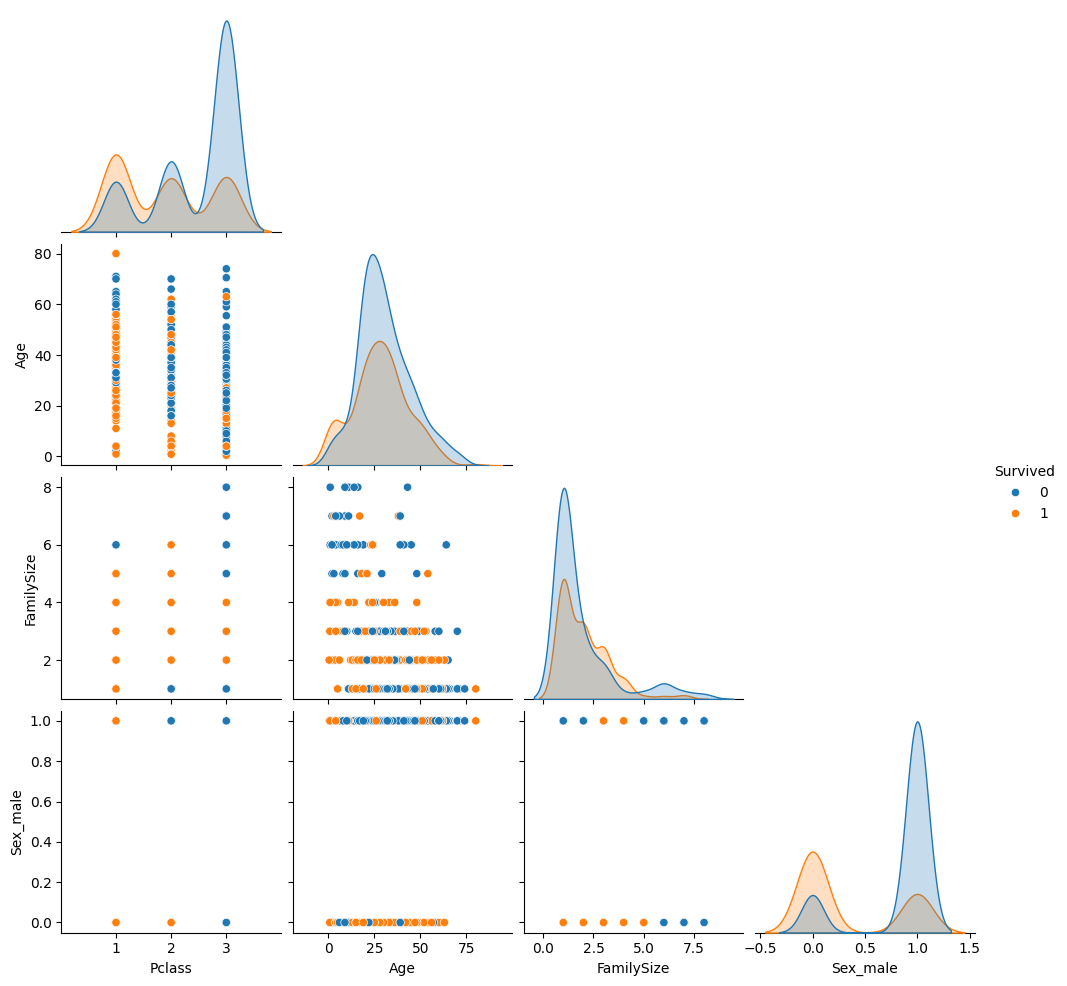

In [18]:
# Drop columns FamilySize, Sex_male, Embarked_Q, Embarked_S
data_clean.drop(columns=["Embarked_Q", "Embarked_S", "Fare"], inplace=True)

sns.pairplot(
    data=data_clean,
    hue="Survived",
    corner=True
)

En observant les différents graphs ci-dessus, on retrouve certains des observations vues dans les 4 premières questions étant donné que certains croisements sont les mêmes que certaines questions.

Pour chaque croisement du pairplot entre 2 variables, on observe que la répartition des survivants semble être influencée par les variables.
Nous pouvons proposer une régression logisitque en utilisant ces variables pour voir si elles permettent de prédire la survie.

In [27]:
X = data_clean.drop(columns=["Survived"])
Y = data_clean["Survived"]
model = sm.Logit(
    Y,
    sm.add_constant(X)
)

model_fitted = model.fit()

print(model_fitted.summary())


Optimization terminated successfully.
         Current function value: 0.448632
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      707
Method:                           MLE   Df Model:                            4
Date:                Sat, 25 Jan 2025   Pseudo R-squ.:                  0.3352
Time:                        11:41:47   Log-Likelihood:                -319.43
converged:                       True   LL-Null:                       -480.45
Covariance Type:            nonrobust   LLR p-value:                 1.891e-68
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7336      0.574      9.995      0.000       4.609       6.858
Pclass        -1.2993      0.

Ce modèle correspond a nos chois finaux de variables, nous l'avons gardé notamment car les p-valuers inter variables sont faibles.

Afin de visualiser le modèle, on peut utiliser part regress gird qui génére une droite par combinaison de variable X avec notre variable d'analyse Survived.

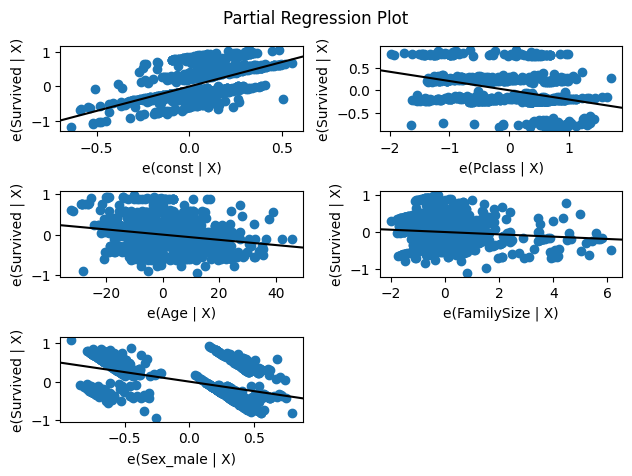

In [26]:
# Visualisation des coefficients du modèle selon les différentes variables
fig = sm.graphics.plot_partregress_grid(model_fitted)
fig.tight_layout(pad=1.0)

Comme l'indiquait les P-valeurs du modèle plus haut, on vois sur les graphiques que la variable age semble être celle qui a le moins d'influence.

La droite "globale" du modèle en haut a droite semble bien suivre les valeurs.


### Q2: Effecter une analyse statistique à l'aide d'un arbre de classification avec comme variable dépendente la variable `Survived` et une profondeur maximale de 4. Visualiser l'arbre et expliquer quelques décisions.

[Text(0.5089285714285714, 0.9, 'Sex_male <= 0.5\ngini = 0.482\nsamples = 712\nvalue = [424, 288]'),
 Text(0.2857142857142857, 0.7, 'Pclass <= 2.5\ngini = 0.372\nsamples = 259\nvalue = [64, 195]'),
 Text(0.39732142857142855, 0.8, 'True  '),
 Text(0.14285714285714285, 0.5, 'Age <= 2.5\ngini = 0.108\nsamples = 157\nvalue = [9, 148]'),
 Text(0.07142857142857142, 0.3, 'FamilySize <= 3.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.03571428571428571, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.10714285714285714, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.21428571428571427, 0.3, 'Age <= 23.5\ngini = 0.098\nsamples = 155\nvalue = [8, 147]'),
 Text(0.17857142857142858, 0.1, 'gini = 0.0\nsamples = 40\nvalue = [0, 40]'),
 Text(0.25, 0.1, 'gini = 0.129\nsamples = 115\nvalue = [8, 107]'),
 Text(0.42857142857142855, 0.5, 'FamilySize <= 4.5\ngini = 0.497\nsamples = 102\nvalue = [55, 47]'),
 Text(0.35714285714285715, 0.3, 'Age <= 7.0\ngini = 0.496\nsamples = 81\nvalue

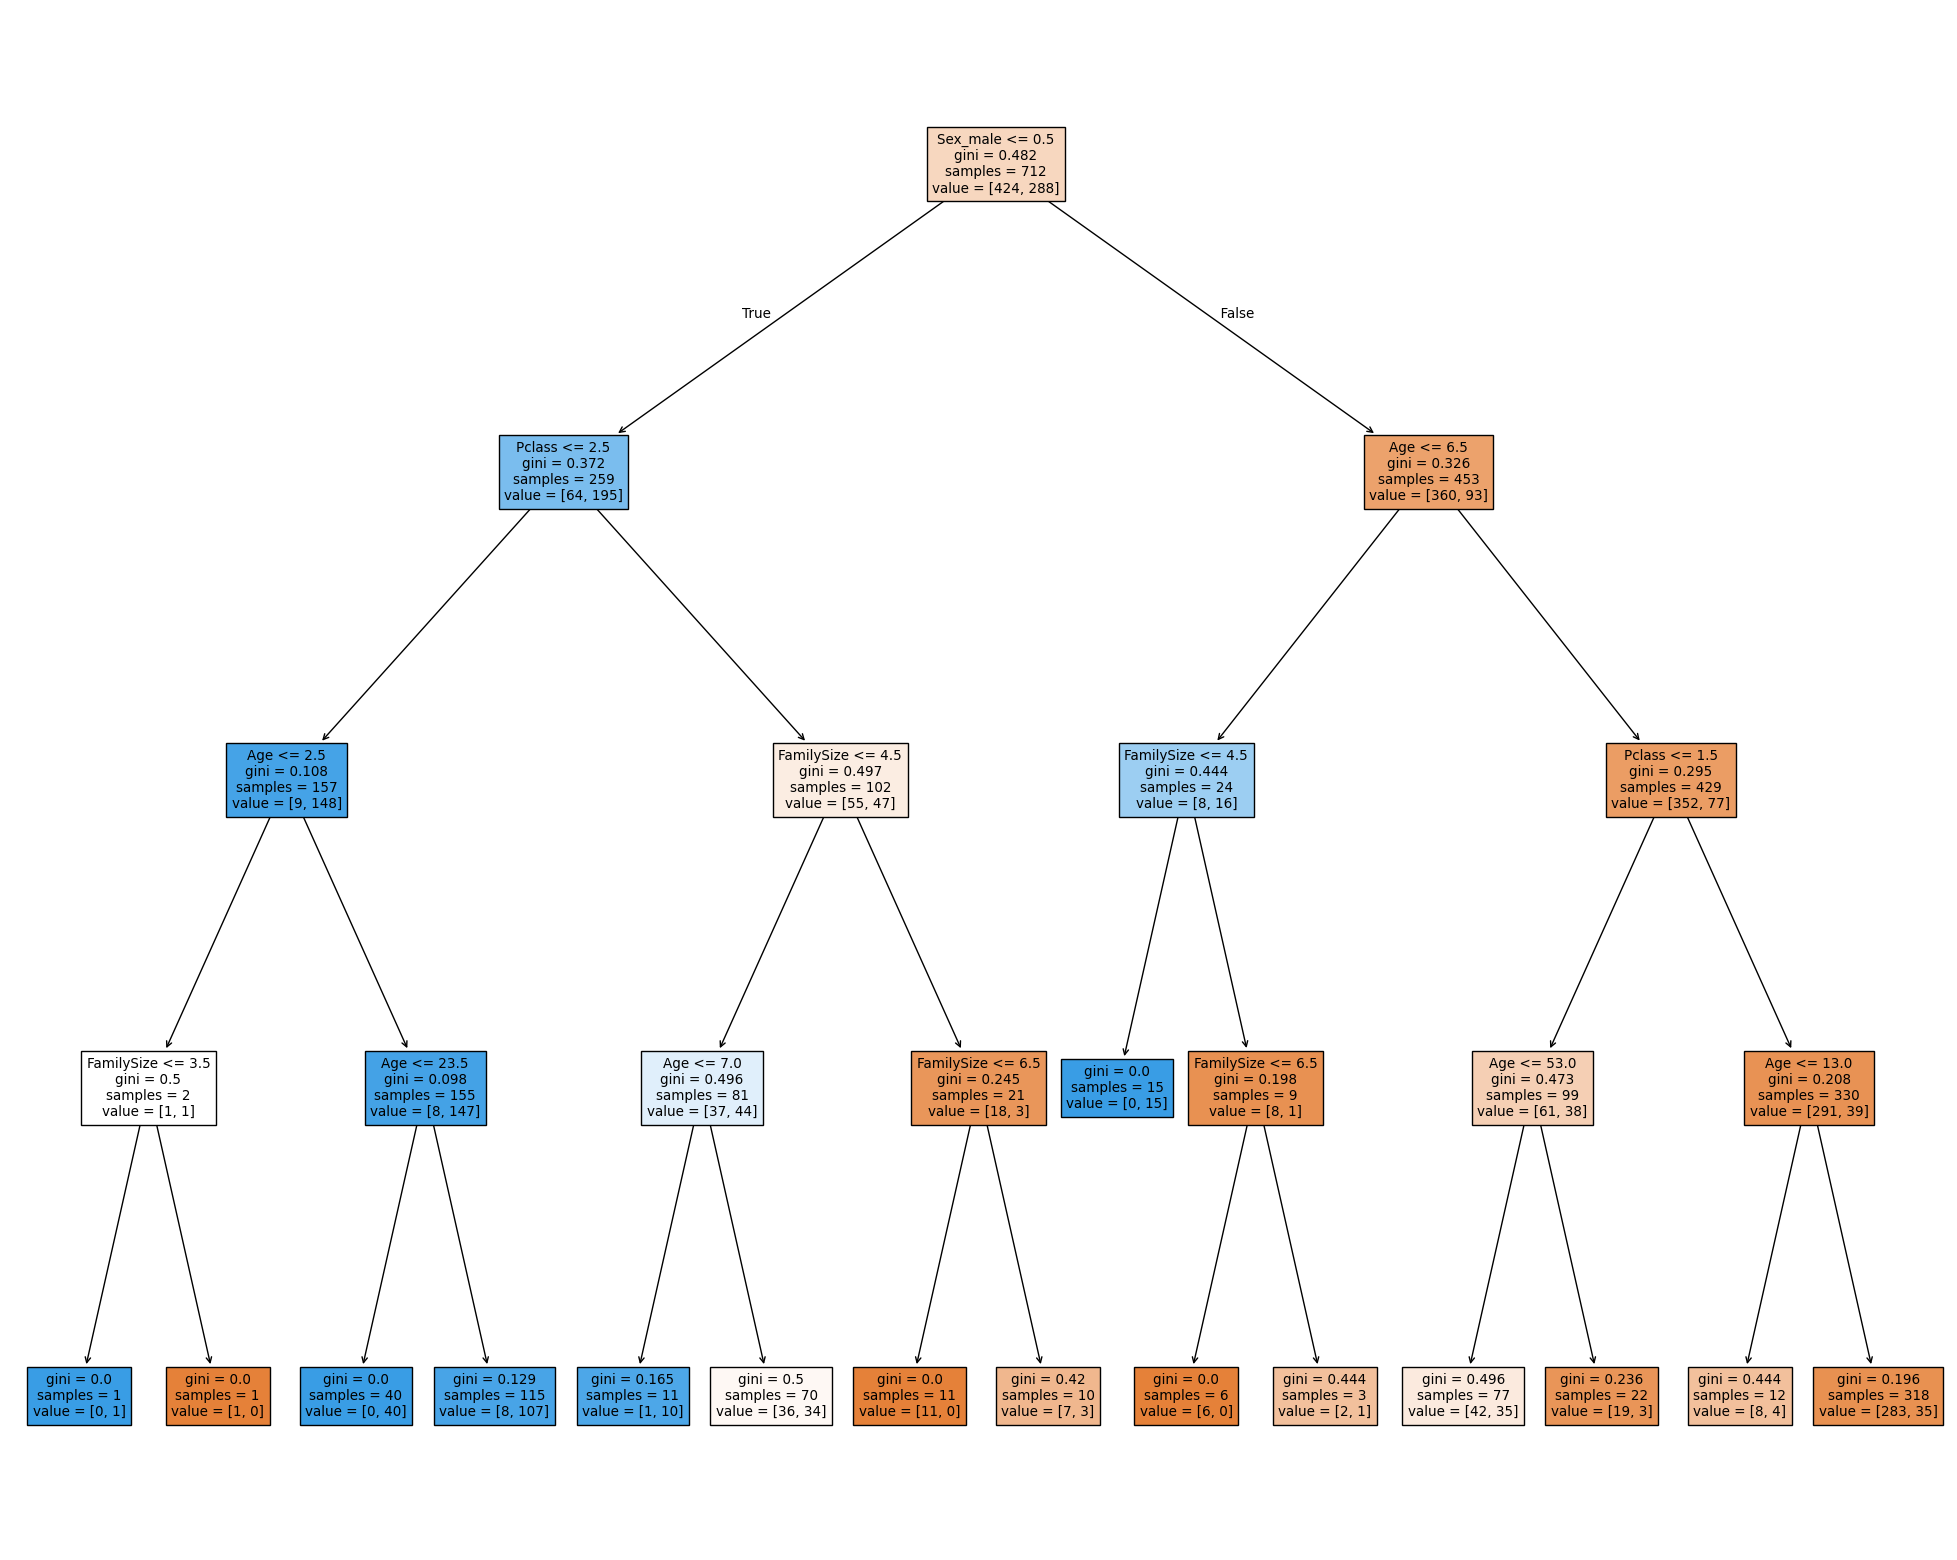

In [39]:
model = DecisionTreeClassifier(max_depth=4)
model_fit = model.fit(X, Y)

tree = plt.figure(figsize=(25, 20))
plot_tree(
    model_fit,
    feature_names=X.columns.tolist(),
    filled=True
)

### Conclusion: Interpréter les résultats des deux analyses statistiques et résumer les points importants de votre étude.

# Sources statistiques
https://www.researchgate.net/figure/Effect-size-Cramers-V-for-the-survival-of-Titanic-passengers-by-class-position-Titanic_tbl1_370188870